## Loading all the requireed Libraries

In [246]:
#Computation libraries
import pandas as pd
import numpy as np
import math

#Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import plotly.express as px

#Stats libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

#Network libraries
import networkx as nx

#Waring libraries
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)

In [219]:
marketingdf = pd.read_csv('google-analytics-public-analyst-case-study_-_marketing_channel_timeseries.csv', parse_dates=True)
userjourneydf = pd.read_csv('google-analytics-public-analyst-case-study_-_pageview_data_bookers.csv',parse_dates=True)

In [220]:
marketingdf

,date_week,isMobile,source,medium,referralPath,region,visits,bounces,transactions,totalTransactionRevenue
0,2017-06-25,False,google,organic,NaN,California,24,4,1,15990000
1,2017-06-25,True,google,organic,NaN,California,37,15,0,0
2,2017-06-25,True,google,organic,NaN,Texas,12,6,0,0
3,2017-06-25,False,google,organic,NaN,New York,9,2,0,0
4,2017-06-25,False,(direct),(none),NaN,not available in demo dataset,32,10,0,0
...,...,...,...,...,...,...,...,...,...,...
1732,2017-07-30,False,(direct),(none),/,Georgia,1,0,1,16590000
1733,2017-07-30,False,(direct),(none),NaN,Oregon,1,0,0,0
1734,2017-07-30,False,groups.google.com,referral,/a/google.com/forum/,California,4,2,0,0
1735,2017-07-30,False,youtube.com,referral,/,not available in demo dataset,1,0,0,0


In [221]:
userjourneydf

,fullVisitorId,transactions,total_visitor_transactions,visitId,visitNumber,hitNumber,pagePath
0,6.911334e+15,NaN,1,1500268117,1,1,/home
1,6.911334e+15,NaN,1,1500268117,1,2,/home
2,6.911334e+15,NaN,1,1500268117,1,3,/home
3,6.911334e+15,NaN,1,1500268117,1,4,/google+redesign/apparel/mens+outerwear/androi...
4,6.911334e+15,NaN,1,1500268117,1,5,/google+redesign/apparel/women+s+google+yoga+j...
...,...,...,...,...,...,...,...
36160,9.974352e+18,1.0,1,1500276722,5,45,/ordercompleted.html
36161,9.974352e+18,1.0,1,1500276722,5,46,/ordercompleted.html
36162,9.974352e+18,1.0,1,1500276722,5,47,/home
36163,9.974352e+18,1.0,1,1500276722,5,48,/home


## Data Pre Processing

In [222]:
# Divide the total transaction revenue by 1000000
marketingdf['totalTransactionRevenue'] = marketingdf['totalTransactionRevenue'] / 1000000

# Calculate the percentage of bounces for each traffic source
marketingdf['bounce_percentage'] = (marketingdf['bounces'] / marketingdf['visits']) * 100

# Calculate the percentage of transactions for each traffic source
marketingdf['conversion_rate'] = (marketingdf['transactions'] / marketingdf['visits']) * 100

# Calculate the average revenue per transaction
marketingdf['average_revenue_per_transaction'] = marketingdf['totalTransactionRevenue'] / source_data['transactions']
marketingdf

,date_week,isMobile,source,medium,referralPath,region,visits,bounces,transactions,totalTransactionRevenue,bounce_percentage,conversion_rate,average_revenue_per_transaction
0,2017-06-25,False,google,organic,NaN,California,24,4,1,15.99,16.666667,4.166667,0.024045
1,2017-06-25,True,google,organic,NaN,California,37,15,0,0.00,40.540541,0.000000,NaN
2,2017-06-25,True,google,organic,NaN,Texas,12,6,0,0.00,50.000000,0.000000,0.000000
3,2017-06-25,False,google,organic,NaN,New York,9,2,0,0.00,22.222222,0.000000,NaN
4,2017-06-25,False,(direct),(none),NaN,not available in demo dataset,32,10,0,0.00,31.250000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,2017-07-30,False,(direct),(none),/,Georgia,1,0,1,16.59,0.000000,100.000000,NaN
1733,2017-07-30,False,(direct),(none),NaN,Oregon,1,0,0,0.00,0.000000,0.000000,NaN
1734,2017-07-30,False,groups.google.com,referral,/a/google.com/forum/,California,4,2,0,0.00,50.000000,0.000000,NaN
1735,2017-07-30,False,youtube.com,referral,/,not available in demo dataset,1,0,0,0.00,0.000000,0.000000,NaN


In [224]:
# Group the data by traffic source and calculate the number of visits, transactions, and total revenue for each source
source_data = marketingdf.groupby(['source','medium']).agg({ 'visits': 'sum','bounces': 'sum', 'transactions': 'sum', 'totalTransactionRevenue': 'sum'}).reset_index()

# Divide the total transaction revenue by 1000000
source_data['totalTransactionRevenue'] = source_data['totalTransactionRevenue'] / 1000000

# Calculate the percentage of bounces for each traffic source
source_data['bounce_percentage'] = (source_data['bounces'] / source_data['visits']) * 100

# Calculate the percentage of transactions for each traffic source
source_data['conversion_rate'] = (source_data['transactions'] / source_data['visits']) * 100

# Calculate the average revenue per transaction
source_data['average_revenue_per_transaction'] = source_data['totalTransactionRevenue'] / source_data['transactions']

# Filter the data for sources with non-zero total revenue and transaction percentage
filtered_data = source_data[(source_data['totalTransactionRevenue'] > 0)& (source_data['conversion_rate'] > 0)]
                      
# Sort the filtered data by transaction percentage in descending order
sorted_data = filtered_data.sort_values(by='conversion_rate', ascending=False)

# Group the source_data by channel and medium
grouped_data = sorted_data.groupby(['source', 'medium']).sum().reset_index()

# Move the bounce_percentage column after bounces column
grouped_data = grouped_data.reindex(columns=['source', 'medium', 'visits', 'bounces', 'bounce_percentage', 'transactions', 'totalTransactionRevenue', 'average_revenue_per_transaction', 'conversion_rate'])
grouped_data

,source,medium,visits,bounces,bounce_percentage,transactions,totalTransactionRevenue,average_revenue_per_transaction,conversion_rate
0,(direct),(none),12486,4460,35.720006,665,0.121966,0.000183,5.325965
1,Partners,affiliate,395,189,47.848101,4,0.000518,0.000129,1.012658
2,bing,organic,58,9,15.517241,2,0.000053,0.000026,3.448276
3,calendar.google.com,referral,2,1,50.000000,1,0.000055,0.000055,50.000000
4,dfa,cpm,270,116,42.962963,5,0.000442,0.000088,1.851852
5,google,cpc,1849,677,36.614386,47,0.003740,0.000080,2.541915
6,google,cpm,382,141,36.910995,16,0.001306,0.000082,4.188482
7,google,organic,14343,5776,40.270515,273,0.025519,0.000093,1.903367
8,m.facebook.com,referral,239,142,59.414226,1,0.000006,0.000006,0.418410
9,mail.google.com,referral,74,16,21.621622,3,0.000186,0.000062,4.054054


In [226]:
#Calculate total transaction revenue for each source
source_revenue = grouped_data.groupby('source').agg({
    "conversion_rate":"mean",
    "totalTransactionRevenue":"sum"
}).sort_values("conversion_rate", ascending=False)
source_revenue

,conversion_rate,totalTransactionRevenue
source,,
calendar.google.com,50.000000,0.000055
outlook.live.com,12.500000,0.000033
yahoo,7.317073,0.000154
(direct),5.325965,0.121966
mail.google.com,4.054054,0.000186
bing,3.448276,0.000053
sites.google.com,3.286385,0.000491
google,2.877921,0.030564
dfa,1.851852,0.000442


## 1. Which marketing source delivers the most bookings?

In [227]:
# Group the data by marketing source and calculate the total bookings
bookings_by_source = grouped_data.groupby('source')['transactions'].sum()

# Find the marketing source with the most bookings
max_bookings_source = bookings_by_source.idxmax()

# Print the marketing source with the most bookings
print("Marketing Source with the Most Bookings:", max_bookings_source)

Marketing Source with the Most Bookings: (direct)


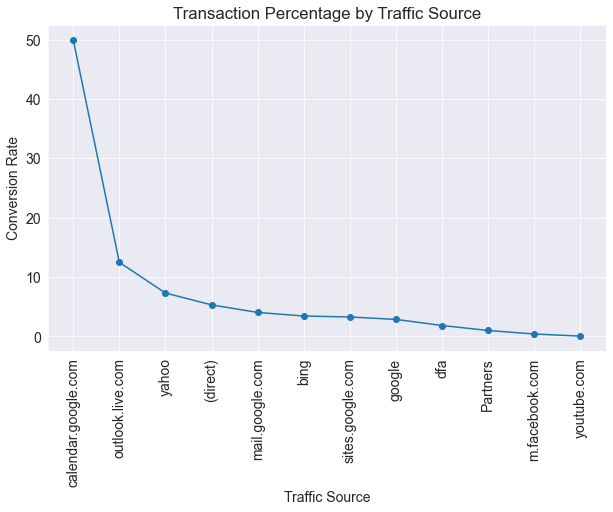

In [230]:
# Plot the line graph with filtered sources
plt.figure(figsize=(10, 6))
plt.plot(source_revenue.index, source_revenue['conversion_rate'], marker='o')
plt.xlabel('Traffic Source')
plt.ylabel('Conversion Rate')
plt.title('Transaction Percentage by Traffic Source')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [231]:
# Calculate the average transaction percentage by medium
average_transaction_by_medium = grouped_data.groupby('medium')['conversion_rate'].mean().sort_values(ascending=False)

# Print the average transaction percentage by medium (sorted)
print("\nAverage Transaction Percentage by Medium (Descending Order):")
print(average_transaction_by_medium)


Average Transaction Percentage by Medium (Descending Order):
medium
referral     11.720956
(none)        5.325965
organic       4.222906
cpm           3.020167
cpc           2.541915
affiliate     1.012658
Name: conversion_rate, dtype: float64


## 2. How does bounce rate vary by marketing channel (source & medium)? Are the differences significant?


In [232]:
# Group the data by 'source' and 'medium'
bounced_data = marketingdf.groupby(['source', 'medium'])['bounce_percentage']

# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*[group.values for name, group in bounced_data])

# Print the test results
print("Kruskal-Wallis Test Results:")
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The differences in bounce rate among marketing channels (source & medium) are significant.")
else:
    print("The differences in bounce rate among marketing channels (source & medium) are not significant.")

Kruskal-Wallis Test Results:
Test Statistic: 200.04732550087755
P-value: 1.0698238857873412e-16
The differences in bounce rate among marketing channels (source & medium) are significant.


The test statistic measures the strenght of evidence against the null hypothesis. In this case, the test statistic is 200.047. The p-value represents the probability of obtaining the observed data if the null hypothesis is true. A p value of 1.069e-16 (very close to zero) indicates strong evidence to reject the null hypothesis. We can conclude that there are significant differences in bounce rates between the marketing channels.

## 3. Which factors most strongly influence conversion rate (transactions / visit)?

In [239]:
#correlation matrix to show the correlation
marketingdf.corr()

,isMobile,visits,bounces,transactions,totalTransactionRevenue,bounce_percentage,conversion_rate,average_revenue_per_transaction
isMobile,1.000000,0.019791,0.059649,-0.082214,-0.064053,0.046190,-0.075137,-0.240707
visits,0.019791,1.000000,0.944232,0.718426,0.379999,-0.034751,0.019147,0.860501
bounces,0.059649,0.944232,1.000000,0.480959,0.281439,0.014207,-0.003825,0.826649
transactions,-0.082214,0.718426,0.480959,1.000000,0.507929,-0.084863,0.135820,0.888688
totalTransactionRevenue,-0.064053,0.379999,0.281439,0.507929,1.000000,-0.044163,0.069559,0.982553
bounce_percentage,0.046190,-0.034751,0.014207,-0.084863,-0.044163,1.000000,-0.171096,-0.128771
conversion_rate,-0.075137,0.019147,-0.003825,0.135820,0.069559,-0.171096,1.000000,0.296242
average_revenue_per_transaction,-0.240707,0.860501,0.826649,0.888688,0.982553,-0.128771,0.296242,1.000000


#### Correlation wrt converstion rate:
the factors that most strongly influence the "transaction_percentage" are:

1. "average_revenue_per_transaction" (correlation coefficient: 0.296242)
2. "transactions" (correlation coefficient: 0.135820)

These two variables have positive correlations with "transaction_percentage," indicating that as the values of these variables increase, the "transaction_percentage" also tends to increase. 
#### Correlation wrt transactions:
"visits" has a strong positive correlation of 0.718426, indicating that there is a positive relationship between the number of visits and the conversion rate.

"totalTransactionRevenue" has a strong positive correlation of 0.507929, suggesting that higher total transaction revenue is associated with a higher conversion rate.

"average_revenue_per_transaction" also shows a strong positive correlation of 0.888688, indicating that a higher average revenue per transaction is associated with a higher conversion rate.

## 4. How complex are the paths a user takes to make a booking?

In [240]:
# Step 1: Filter sessions with transactions
bookings_data = userjourneydf[userjourneydf['transactions'] > 0]

# Step 2: Group data by unique identifier
user_paths = bookings_data.groupby('fullVisitorId')['pagePath'].apply(list)

# Step 3: Calculate complexity of paths
path_complexity = user_paths.apply(lambda x: len(set(x)))

# Example output: Average complexity of paths
average_complexity = path_complexity.mean()
print("Average complexity of paths:", average_complexity)


Average complexity of paths: 15.275974025974026


In [241]:
# Group data by user session and aggregate the page paths
user_journeys = userjourneydf.groupby(['fullVisitorId', 'visitId'])['pagePath'].apply(list)

# Calculate the length of each unique user journey
journey_lengths = user_journeys.apply(len)

# Analyze the distribution of journey lengths
journey_lengths.describe()

count    2440.000000
mean       14.821721
std        15.181632
min         1.000000
25%         3.000000
50%        11.000000
75%        22.000000
max       175.000000
Name: pagePath, dtype: float64

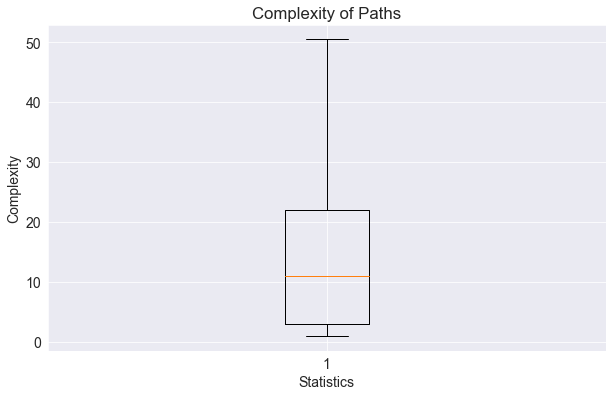

In [242]:
# Define the statistics
count = 2440
mean = 14.821721
std = 15.181632
min_val = 1
q1 = 3
median = 11
q3 = 22
max_val = 175

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Calculate the upper whisker value
upper_whisker = np.min([q3 + 1.5 * iqr, max_val])

# Create a list of the statistics
stats = [min_val, q1, median, q3, upper_whisker]

# Create the box plot
plt.boxplot(stats)

# Add a title and labels to the plot
plt.title("Complexity of Paths")
plt.xlabel("Statistics")
plt.ylabel("Complexity")

# Show the plot
plt.show()


User experience and conversion rate: A lower complexity of paths, as indicated by the 25th percentile value of 3, suggests that a quarter of the users took a relatively simple and direct path to complete a successful transaction. This can be seen as positive, as it indicates a streamlined user experience that may contribute to higher conversion rates.

Room for improvement: The 75th percentile value of 22 suggests that a significant portion of users had more complex paths to complete their transactions. This could imply that there is room for optimization to simplify the user journey and reduce friction, potentially leading to improved conversion rates and user satisfaction.

## 5. What appears to be the biggest opportunity to drive incremental bookings?

In [243]:
# Group the userjourneydf by pagePath and calculate the total transactions and unique user count for each page
page_transactions = userjourneydf.groupby('pagePath')['transactions'].sum()
page_users = userjourneydf.groupby('pagePath')['fullVisitorId'].nunique()

# Create the transaction_count_df DataFrame
transaction_count_df = pd.DataFrame({'pagePath': page_transactions.index,
                                    'transaction_count': page_transactions.values,
                                    'user_count': page_users.values})

# Sort the DataFrame by transaction_count in descending order
transaction_count_df = transaction_count_df.sort_values(by='transaction_count', ascending=False)

# Reset the index of the DataFrame
transaction_count_df = transaction_count_df.reset_index(drop=True)
transaction_count_df = transaction_count_df[transaction_count_df['transaction_count'] > 0]
transaction_count_df

,pagePath,transaction_count,user_count
0,/basket.html,4440.0,924
1,/ordercompleted.html,2281.0,924
2,/payment.html,2114.0,924
3,/yourinfo.html,1847.0,922
4,/signin.html,1267.0,783
...,...,...,...
377,/google+redesign/apparel/men+s+t+shirts/google...,1.0,2
378,/google+redesign/apparel/womens+tshirts/google...,1.0,3
379,/google+redesign/apparel/men+s+t+shirts/google...,1.0,1
380,/google+redesign/apparel/mens+tshirts/google+m...,1.0,2


In [245]:
# Step 1: Choosing relevant columns for the graph representation
relevant_columns = ["fullVisitorId", "visitId", "visitNumber", "pagePath", "transactions"]
data = userjourneydf[relevant_columns]

# Step 2: Construct a graph representation
graph = nx.DiGraph()
edges = data.groupby(["fullVisitorId", "visitId", "visitNumber"])["pagePath"].apply(list)
for edge in edges:
    for i in range(1, len(edge)):
        source_node = edge[i-1]
        target_node = edge[i]
        graph.add_edge(source_node, target_node)

# Step 3: Calculate PageRank
pagerank_scores = nx.pagerank(graph)

# Step 4: Create DataFrame of sorted page paths, PageRank scores, and successful transactions
sorted_pagepaths = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
successful_transactions = []
for pagepath in sorted_pagepaths:
    transactions = data[data["pagePath"] == pagepath]["transactions"].sum()
    successful_transactions.append(transactions)
    
# Step 5: Create DataFrame with page paths, PageRank scores, and successful transactions
df_sorted = pd.DataFrame({'PagePath': sorted_pagepaths, 'PageRankScore': [pagerank_scores[path] for path in sorted_pagepaths],
                          'SuccessfulTransitions': successful_transactions})

# Print the sorted DataFrame
print(df_sorted)


                                              PagePath  PageRankScore  \
0                                         /basket.html       0.054431   
1                                                /home       0.022066   
2          /google+redesign/apparel/mens/mens+t+shirts       0.021606   
3                                          /store.html       0.017545   
4                                        /asearch.html       0.017067   
..                                                 ...            ...   
388  /google+redesign/apparel/kids/kids+toddler/goo...       0.000398   
389  /google+redesign/apparel/men+s+google+full+zip...       0.000386   
390        /google redesign/apparel/mens/mens t shirts       0.000386   
391                    /google+redesign/nest/nest-usa.       0.000386   
392  /google+redesign/drinkware/google+25+oz+clear+...       0.000386   

     SuccessfulTransitions  
0                   4440.0  
1                   1155.0  
2                    531.0  
3      